# CELL 1: INSTALASI DAN IMPORT LIBRARY

In [ ]:
!pip install nltk scikit-learn wordcloud gensim seaborn matplotlib tensorflow numpy pandas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import string
import time
import joblib
from datetime import datetime

# Text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)

# Machine Learning & Deep Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

warnings.filterwarnings('ignore')
print("✅ Library berhasil diimport dan di-setup!")
print(f"✅ TensorFlow version: {tf.__version__}")

✅ Library berhasil diimport dan di-setup!
✅ TensorFlow version: 2.19.0


# CELL 2: MEMUAT DATASET

In [ ]:
# --- PENTING ---
# Pastikan file CSV dari notebook scraping Anda sudah di-upload ke environment Colab.
# Ganti nama file di bawah ini jika berbeda.
DATASET_FILE = 'gps_reviews_dataset_20250904_034801.csv'

try:
    df = pd.read_csv(DATASET_FILE)
    print(f"✅ Dataset '{DATASET_FILE}' berhasil dimuat!")
    print(f"   - Jumlah data awal: {len(df):,} baris")
    print(f"   - Kolom: {list(df.columns)}")
except FileNotFoundError:
    print(f"❌ ERROR: File '{DATASET_FILE}' tidak ditemukan!")
    print("   - Harap upload file CSV hasil scraping Anda dan sesuaikan nama filenya.")
    df = pd.DataFrame() # Buat dataframe kosong agar tidak error di cell berikutnya

✅ Dataset 'gps_reviews_dataset_20250904_034801.csv' berhasil dimuat!
   - Jumlah data awal: 14,308 baris
   - Kolom: ['app_id', 'app_name', 'review_id', 'user_name', 'content', 'score', 'thumbs_up_count', 'at', 'sentiment']


# CELL 3: EKSPLORASI DATA AWAL (EDA)


🔍 ANALISIS EKSPLORASI DATA AWAL (EDA)


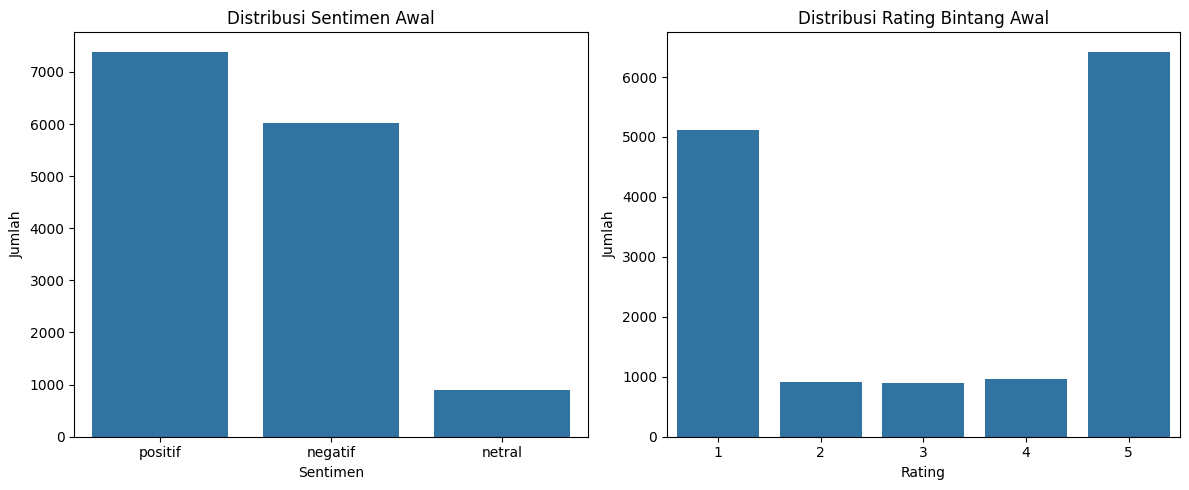

In [ ]:
if not df.empty:
    print("\n🔍 ANALISIS EKSPLORASI DATA AWAL (EDA)")

    # Visualisasi Distribusi Sentimen Awal
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(x='sentiment', data=df, order=['positif', 'negatif', 'netral'])
    plt.title('Distribusi Sentimen Awal')
    plt.xlabel('Sentimen')
    plt.ylabel('Jumlah')

    # Visualisasi Distribusi Rating
    plt.subplot(1, 2, 2)
    sns.countplot(x='score', data=df, order=[1, 2, 3, 4, 5])
    plt.title('Distribusi Rating Bintang Awal')
    plt.xlabel('Rating')
    plt.ylabel('Jumlah')
    plt.tight_layout()
    plt.show()


# CELL 4: TEXT PREPROCESSING

In [ ]:
if not df.empty:
    print("\n🧹 PROSES PEMBERSIHAN TEKS (PREPROCESSING)")

    # Setup stopwords (Indonesian + English) - sama seperti di notebook Anda
    indonesian_stopwords = set(['yang', 'dan', 'di', 'ke', 'dari', 'dalam', 'untuk', 'pada', 'dengan', 'oleh', 'adalah', 'akan', 'telah', 'sudah', 'masih', 'dapat', 'bisa', 'harus', 'belum', 'ini', 'itu', 'tersebut', 'seperti', 'antara', 'karena', 'sehingga', 'tetapi', 'atau', 'jika', 'maka', 'agar', 'supaya', 'bahwa', 'dimana', 'ketika', 'saat', 'saya', 'anda', 'kamu', 'dia', 'mereka', 'kita', 'kami', 'kalian', 'tidak', 'bukan', 'jangan', 'tanpa', 'kecuali', 'selain', 'sangat', 'lebih', 'paling', 'cukup', 'agak', 'sedikit', 'banyak', 'app', 'aplikasi', 'google', 'play', 'store', 'android', 'ios'])
    english_stopwords = set(stopwords.words('english'))
    all_stopwords = indonesian_stopwords.union(english_stopwords)

    def advanced_preprocess(text):
        if pd.isna(text): return ""
        text = str(text).lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'\S+@\S+', '', text)
        text = re.sub(r'@\w+|#\w+', '', text)
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', ' ', text) # Hapus tanda baca
        text = re.sub(r'\s+', ' ', text).strip()
        tokens = word_tokenize(text)
        filtered_tokens = [token for token in tokens if token.lower() not in all_stopwords and len(token) > 2]
        return ' '.join(filtered_tokens)

    # Terapkan preprocessing
    print("   - Menerapkan fungsi preprocessing pada kolom 'content'...")
    df['processed_content'] = df['content'].apply(advanced_preprocess)

    # Hapus baris yang kontennya kosong setelah diproses
    initial_len = len(df)
    df.dropna(subset=['processed_content'], inplace=True)
    df = df[df['processed_content'].str.len() > 5]
    final_len = len(df)

    print(f"   - Preprocessing selesai. Data tersisa: {final_len:,} (dihapus {initial_len - final_len:,})")
    print("\n   - Contoh hasil:")
    print(f"     Original : \"{df['content'].iloc[10]}\"")
    print(f"     Processed: \"{df['processed_content'].iloc[10]}\"")


🧹 PROSES PEMBERSIHAN TEKS (PREPROCESSING)
   - Menerapkan fungsi preprocessing pada kolom 'content'...
   - Preprocessing selesai. Data tersisa: 14,053 (dihapus 255)

   - Contoh hasil:
     Original : "oke banget"
     Processed: "oke banget"


# CELL 5: PENANGANAN CLASS IMBALANCE


⚖️ PENANGANAN CLASS IMBALANCE
   - Distribusi sebelum oversampling:
sentiment
positif    7216
negatif    5946
netral      891
Name: count, dtype: int64

   - Distribusi setelah oversampling:
sentiment
negatif    7216
positif    7216
netral     7216
Name: count, dtype: int64


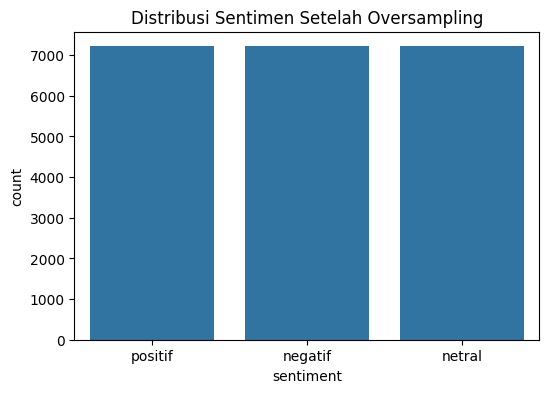

In [ ]:
if not df.empty:
    print("\n⚖️ PENANGANAN CLASS IMBALANCE")

    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(df[['processed_content']], df['sentiment'])

    df_balanced = pd.DataFrame(X_resampled, columns=['processed_content'])
    df_balanced['sentiment'] = y_resampled

    print("   - Distribusi sebelum oversampling:")
    print(df['sentiment'].value_counts())
    print("\n   - Distribusi setelah oversampling:")
    print(df_balanced['sentiment'].value_counts())

    # Visualisasi setelah balancing
    plt.figure(figsize=(6, 4))
    sns.countplot(x='sentiment', data=df_balanced, order=['positif', 'negatif', 'netral'])
    plt.title('Distribusi Sentimen Setelah Oversampling')
    plt.show()

# CELL 6: FEATURE EXTRACTION (TOKENIZATION & PADDING)

In [ ]:
if 'df_balanced' in locals():
    print("\n🔡 FEATURE EXTRACTION UNTUK DEEP LEARNING")

    # Pisahkan fitur dan label
    texts = df_balanced['processed_content'].values
    labels = df_balanced['sentiment'].values

    # Label Encoding
    encoder = LabelEncoder()
    labels_encoded = encoder.fit_transform(labels)

    # Tokenisasi
    vocab_size = 10000
    oov_tok = "<OOV>"
    tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
    tokenizer.fit_on_texts(texts)

    # Konversi teks ke sekuens angka
    sequences = tokenizer.texts_to_sequences(texts)

    # Padding
    max_length = 100 # Panjang maksimum sekuens
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

    print(f"   - Ukuran vocabulary: {len(tokenizer.word_index)}")
    print(f"   - Bentuk data padded: {padded_sequences.shape}")
    print(f"   - Bentuk data label: {labels_encoded.shape}")


🔡 FEATURE EXTRACTION UNTUK DEEP LEARNING
   - Ukuran vocabulary: 14361
   - Bentuk data padded: (21648, 100)
   - Bentuk data label: (21648,)


# CELL 7: DATA SPLITTING UNTUK MODEL


In [ ]:
if 'padded_sequences' in locals():
    print("\n✂️ PEMBAGIAN DATA (TRAIN & TEST)")

    X_train, X_test, y_train, y_test = train_test_split(
        padded_sequences,
        labels_encoded,
        test_size=0.2, # Sesuai skema 80/20
        random_state=42,
        stratify=labels_encoded
    )

    print(f"   - Data Latih (Train): {X_train.shape}, {y_train.shape}")
    print(f"   - Data Uji (Test)  : {X_test.shape}, {y_test.shape}")


✂️ PEMBAGIAN DATA (TRAIN & TEST)
   - Data Latih (Train): (17318, 100), (17318,)
   - Data Uji (Test)  : (4330, 100), (4330,)


# CELL 8: PEMBUATAN & PELATIHAN MODEL (3 SKEMA)

In [ ]:
if 'X_train' in locals():
    print("\n🤖 PEMBUATAN DAN PELATIHAN MODEL DEEP LEARNING")

    # Konfigurasi umum
    embedding_dim = 64
    num_classes = len(encoder.classes_)

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

    histories = {}

    # --- SKEMA 1: Model LSTM Sederhana ---
    print("\n--- [SKEMA 1] Melatih Model LSTM Sederhana ---")
    model_lstm = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        LSTM(64),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_lstm.summary()

    history_lstm = model_lstm.fit(
        X_train, y_train,
        epochs=15,
        batch_size=64,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr]
    )
    histories['LSTM'] = history_lstm

    # --- SKEMA 2: Model Bidirectional LSTM ---
    print("\n--- [SKEMA 2] Melatih Model Bidirectional LSTM ---")
    model_bilstm = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        Bidirectional(LSTM(64, return_sequences=True)),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model_bilstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_bilstm.summary()

    history_bilstm = model_bilstm.fit(
        X_train, y_train,
        epochs=15,
        batch_size=64,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr]
    )
    histories['BiLSTM'] = history_bilstm

    # --- SKEMA 3: Model BiLSTM dengan Dropout lebih banyak ---
    # Variasi pada arsitektur model
    print("\n--- [SKEMA 3] Melatih Model BiLSTM dengan Dropout lebih banyak ---")
    model_bilstm_v2 = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        Bidirectional(LSTM(128, return_sequences=True)),
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.6),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model_bilstm_v2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_bilstm_v2.summary()

    history_bilstm_v2 = model_bilstm_v2.fit(
        X_train, y_train,
        epochs=15,
        batch_size=64,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr]
    )
    histories['BiLSTM_v2'] = history_bilstm_v2


🤖 PEMBUATAN DAN PELATIHAN MODEL DEEP LEARNING

--- [SKEMA 1] Melatih Model LSTM Sederhana ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 26s 87ms/step - accuracy: 0.3327 - loss: 1.0992 - val_accuracy: 0.3335 - val_loss: 1.0986 - learning_rate: 0.0010
Epoch 2/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - accuracy: 0.3294 - loss: 1.0988 - val_accuracy: 0.3333 - val_loss: 1.0986 - learning_rate: 0.0010
Epoch 3/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 39s 76ms/step - accuracy: 0.3322 - loss: 1.0987 - val_accuracy: 0.3333 - val_loss: 1.0986 - learning_rate: 0.0010
Epoch 4/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 42s 79ms/step - accuracy: 0.3331 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986 - learning_rate: 2.0000e-04
Epoch 5/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.3349 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986 - learning_rate: 2.0000e-04
Epoch 6/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 39s 77ms/step - accuracy: 0.3400 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986 - learning_rate: 4.0000e-05
Epoch 7/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 44s 145ms/step - accuracy: 0.5069 - loss: 0.9675 - val_accuracy: 0.7700 - val_loss: 0.5925 - learning_rate: 0.0010
Epoch 2/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 40s 143ms/step - accuracy: 0.8184 - loss: 0.4945 - val_accuracy: 0.8545 - val_loss: 0.4150 - learning_rate: 0.0010
Epoch 3/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 39s 143ms/step - accuracy: 0.8879 - loss: 0.3359 - val_accuracy: 0.8670 - val_loss: 0.3770 - learning_rate: 0.0010
Epoch 4/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 42s 145ms/step - accuracy: 0.9153 - loss: 0.2547 - val_accuracy: 0.8831 - val_loss: 0.3607 - learning_rate: 0.0010
Epoch 5/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 39s 144ms/step - accuracy: 0.9332 - loss: 0.2045 - val_accuracy: 0.8778 - val_loss: 0.3672 - learning_rate: 0.0010
Epoch 6/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 43s 151ms/step - accuracy: 0.9460 - loss: 0.1695 - val_accuracy: 0.8797 - val_loss: 0.3804 - learning_rate: 0.0010
Epoch 7/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 39s 144ms/step - accuracy: 0.9

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 109s 385ms/step - accuracy: 0.4495 - loss: 1.0069 - val_accuracy: 0.5887 - val_loss: 1.0171 - learning_rate: 0.0010
Epoch 2/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 103s 381ms/step - accuracy: 0.7056 - loss: 0.7010 - val_accuracy: 0.8321 - val_loss: 0.4595 - learning_rate: 0.0010
Epoch 3/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 140s 375ms/step - accuracy: 0.8658 - loss: 0.4000 - val_accuracy: 0.8594 - val_loss: 0.4007 - learning_rate: 0.0010
Epoch 4/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 143s 378ms/step - accuracy: 0.9057 - loss: 0.2917 - val_accuracy: 0.8762 - val_loss: 0.3760 - learning_rate: 0.0010
Epoch 5/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 100s 367ms/step - accuracy: 0.9259 - loss: 0.2254 - val_accuracy: 0.8797 - val_loss: 0.3935 - learning_rate: 0.0010
Epoch 6/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 144s 375ms/step - accuracy: 0.9376 - loss: 0.1850 - val_accuracy: 0.8843 - val_loss: 0.3916 - learning_rate: 0.0010
Epoch 7/15
271/271 ━━━━━━━━━━━━━━━━━━━━ 140s 370ms/step - accura

# CELL 9: EVALUASI MODEL


📈 EVALUASI PERFORMA MODEL

--- Hasil Akurasi Setiap Skema ---
  - Model LSTM:
    - Akurasi Training: 33.34%
    - Akurasi Testing (Validation): 33.35%
    - ❌ Tidak memenuhi kriteria minimal
  - Model BiLSTM:
    - Akurasi Training: 95.89%
    - Akurasi Testing (Validation): 88.91%
    - ✅ Memenuhi kriteria > 85%
  - Model BiLSTM_v2:
    - Akurasi Training: 95.55%
    - Akurasi Testing (Validation): 89.10%
    - ✅ Memenuhi kriteria > 85%

🏆 Model terbaik adalah: BiLSTM_v2 dengan akurasi validasi 89.10%


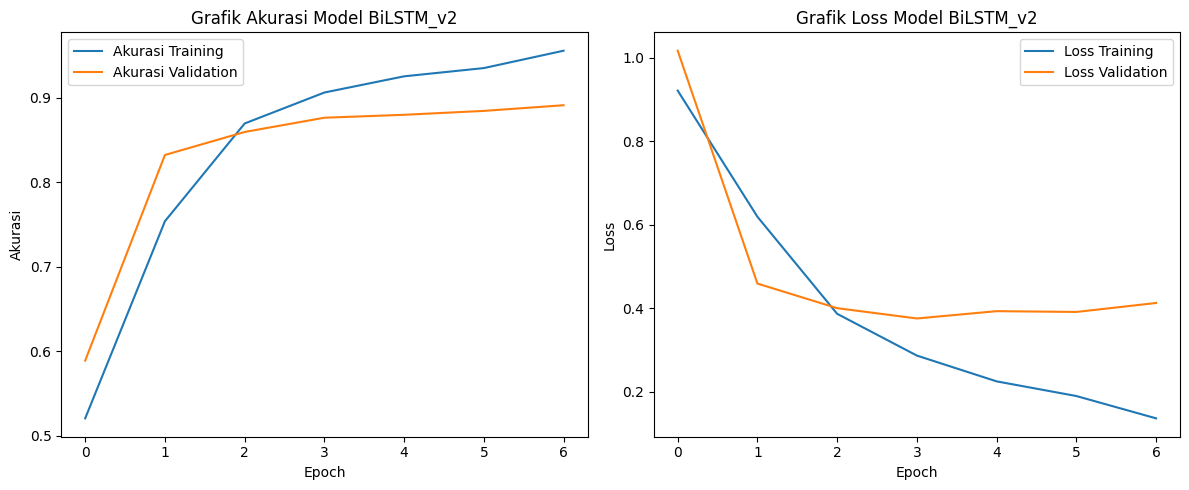

In [ ]:
if 'histories' in locals():
    print("\n📈 EVALUASI PERFORMA MODEL")

    # Cari model terbaik berdasarkan validation accuracy
    best_model_name = ''
    best_val_accuracy = 0

    results = {}

    models = {
        "LSTM": model_lstm,
        "BiLSTM": model_bilstm,
        "BiLSTM_v2": model_bilstm_v2
    }

    for name, history in histories.items():
        val_acc = max(history.history['val_accuracy'])
        train_acc = max(history.history['accuracy'])
        results[name] = {'train_acc': train_acc, 'val_acc': val_acc}
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_model_name = name

    print("\n--- Hasil Akurasi Setiap Skema ---")
    for name, accs in results.items():
        print(f"  - Model {name}:")
        print(f"    - Akurasi Training: {accs['train_acc']:.2%}")
        print(f"    - Akurasi Testing (Validation): {accs['val_acc']:.2%}")
        # Validasi Kriteria Dicoding
        if accs['train_acc'] > 0.92 and accs['val_acc'] > 0.92:
            print("    - ✅ Memenuhi kriteria > 92%")
        elif accs['val_acc'] > 0.85:
            print("    - ✅ Memenuhi kriteria > 85%")
        else:
            print("    - ❌ Tidak memenuhi kriteria minimal")

    print(f"\n🏆 Model terbaik adalah: {best_model_name} dengan akurasi validasi {best_val_accuracy:.2%}")
    best_model = models[best_model_name]

    # Plotting history model terbaik
    best_history = histories[best_model_name]
    plt.figure(figsize=(12, 5))

    # Plot Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(best_history.history['accuracy'], label='Akurasi Training')
    plt.plot(best_history.history['val_accuracy'], label='Akurasi Validation')
    plt.title(f'Grafik Akurasi Model {best_model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Akurasi')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(best_history.history['loss'], label='Loss Training')
    plt.plot(best_history.history['val_loss'], label='Loss Validation')
    plt.title(f'Grafik Loss Model {best_model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


# CELL 10: INFERENCE (PENGUJIAN DENGAN TEKS BARU)

In [ ]:
if 'best_model' in locals():
    print("\n🧪 INFERENCE - MENGUJI MODEL DENGAN KALIMAT BARU")

    def predict_sentiment(text):
        # Preprocessing teks input
        processed_text = advanced_preprocess(text)

        # Konversi ke sekuens
        sequence = tokenizer.texts_to_sequences([processed_text])

        # Padding
        padded = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

        # Prediksi
        prediction = best_model.predict(padded)
        predicted_class_index = np.argmax(prediction)

        # Konversi indeks ke label sentimen
        predicted_sentiment = encoder.inverse_transform([predicted_class_index])[0]

        return predicted_sentiment, prediction[0][predicted_class_index]

    # Contoh kalimat untuk diuji
    test_sentences = [
        "Aplikasi ini luar biasa, sangat membantu pekerjaan saya sehari-hari!",
        "Sering banget error dan keluar sendiri, tolong segera diperbaiki developernya.",
        "Lumayan sih, fiturnya cukup tapi kadang masih suka lemot.",
        "Keren, desainnya bagus dan mudah digunakan.",
        "Kecewa berat, setelah update malah jadi banyak bug."
    ]

    for sentence in test_sentences:
        sentiment, confidence = predict_sentiment(sentence)
        print(f"\nInput     : \"{sentence}\"")
        print(f"Prediksi  : {sentiment.upper()} (Confidence: {confidence:.2%})")


🧪 INFERENCE - MENGUJI MODEL DENGAN KALIMAT BARU
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step

Input     : "Aplikasi ini luar biasa, sangat membantu pekerjaan saya sehari-hari!"
Prediksi  : POSITIF (Confidence: 95.50%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

Input     : "Sering banget error dan keluar sendiri, tolong segera diperbaiki developernya."
Prediksi  : NETRAL (Confidence: 97.84%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

Input     : "Lumayan sih, fiturnya cukup tapi kadang masih suka lemot."
Prediksi  : NETRAL (Confidence: 52.87%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

Input     : "Keren, desainnya bagus dan mudah digunakan."
Prediksi  : POSITIF (Confidence: 99.19%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

Input     : "Kecewa berat, setelah update malah jadi banyak bug."
Prediksi  : NEGATIF (Confidence: 89.22%)


In [ ]:
!pip freeze > requirements.txt